# **Introduction to PyTorch** - Logistic Regression, MLP, and MNIST

**Duke Machine Learning Winter School: Computer Vision 2022**

**Code by Billy Carson**

In this notebook, we're going to gain familiarity with the PyTorch deep learning framework by building PyTorch models to perform handwritten digit classification.


## **1. Setting Up the Enivronment**

### 1.1. Import libraries, modules, and functions

First, we need to import necessary libraries, modules, and functions we'll use throughout this tutorial. To give ourselves access to the offerings of the PyTorch library, we'll import the [torch](https://pytorch.org/docs/stable/torch.html) package and the [torch.nn](https://pytorch.org/docs/stable/nn.html) module. Later, you can cut down on import bloat by only importing specific modules, functions, and objects that you'll need for your project. For now, we'll keep it simple by just using these two import statements.


In [1]:
# Define random state
random_state = 0

# Import libraries, modules, and functions
import time
from idx2numpy import convert_from_file
import numpy as np
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn


### 1.2. GPU/CUDA availability

When setting up your coding environment for a project or experiment, it's important that we are aware of the available computing resources. The resources we have access to will determine what models we can or can't use and the amount of data we can load into memory, among other considerations. For this tutorial, since we are dealing with simpler machine learning models, we won't need access to a [Graphics Processing Unit](https://en.wikipedia.org/wiki/Graphics_processing_unit) (GPU). GPUs help speed up the training of deep learning models by parallelizing many computations intead of computing sequentially. This parallelization is critical when training more complex models like [Convolutional Neural Networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs), and without it these models would take prohibitively long to train.

We can check whether or not our environment has access to a GPU by calling the [`torch.cuda.is_available()`](https://pytorch.org/docs/stable/cuda.html) function. [CUDA](https://developer.nvidia.com/about-cuda) is a parallel computing platform and programming model developed by Nvidia for general computing on its own GPUs. This function will tell us if CUDA is available in this computing environment. Since we don't need/have access to a GPU, `torch.cuda.is_available()` should return `False`.


In [2]:
# Display GPU/CUDA availability
print('\nCUDA availability:  %s\n' % (torch.cuda.is_available()))



CUDA availability:  False



## **2. Loading and Preparing the Data**

One of the first (and often most important) steps in a machine learning pipeline is preparing the data. Here, we will load the MNIST dataset of images of handwritten digits and format this data so it can be used with PyTorch models.


### 2.1. Load MNIST dataset

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) is very popular machine learning dataset, consisting of 70,000 grayscale, 28x28 images of handwritten digits.  We'll be using it as our example dataset for this section of the tutorial, with the goal being to predict which digit is depicted in each image.

<img src="figures/mnist_examples.png" alt="drawing" width="500"/>

First, let's load the training and test sets of MNIST. The MNIST dataset needs to be converted to a type that can be operated on by PyTorch models. MNIST data will first be loaded from IDX file format and converted into NumPy arrays using the [idx2numpy](https://pypi.org/project/idx2numpy/) package. [NumPy](https://numpy.org) is a commonly-used Python library which provides support for multi-dimensional arrays and matrices, along with a variety of mathematical functions to operate on these arrays. In Python data science and machine learning pipelines, [NumPy arrays](https://numpy.org/doc/stable/reference/generated/numpy.array.html) are commonly used to store data and facilitate quick and efficient operations on array-like data.


In [3]:
# Load NumPy arrays of MNIST dataset
mnist_data_dir = '/datasets/mnist/'
X_raw_train_npy = convert_from_file(mnist_data_dir + 'train-images-idx3-ubyte')
y_train_npy = convert_from_file(mnist_data_dir + 'train-labels-idx1-ubyte')
X_raw_test_npy = convert_from_file(mnist_data_dir + 't10k-images-idx3-ubyte')
y_test_npy = convert_from_file(mnist_data_dir + 't10k-labels-idx1-ubyte')

# Display class type
print('\nClass types:')
print('  Images:  %s' % (type(X_raw_train_npy)))
print('  Labels:  %s' % (type(y_train_npy)))



Class types:
  Images:  <class 'numpy.ndarray'>
  Labels:  <class 'numpy.ndarray'>


### 2.2 Convert data from NumPy arrays to PyTorch tensors

Now, MNIST data stored as NumPy arrays must be converted to [PyTorch tensors](https://pytorch.org/docs/stable/tensors.html) so that this data can be operated on by PyTorch models.


In [4]:
# Convert NumPy arrays to PyTorch tensors
X_raw_train = torch.from_numpy(X_raw_train_npy)
y_train = torch.from_numpy(y_train_npy)
X_raw_test = torch.from_numpy(X_raw_test_npy)
y_test = torch.from_numpy(y_test_npy)


### 2.3. Explore data/PyTorch tensors

Tensors are a specialized data structure very similar to arrays and matrices that house data in $N$ dimensions. Tensors can be thought of as generalizations of matrices (which are specifically 2-dimensional tensors) to $N$-dimensional space. 

In PyTorch, tensors are used to encode data, model inputs, model outputs, and model parameters. [PyTorch tensors](https://pytorch.org/docs/stable/tensors.html) are objects similar to [NumPy ndarrays](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html), except that tensors can run on GPUs or other hardware accelerators. Tensors are also optimized for automatic differentiation with [`autograd`](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html), PyTorch’s automatic differentiation engine that powers neural network training. Here, where call the tensor method `shape()` to get an idea of the size and dimensionality of our data.


In [5]:
# Display training data dimensionality
print('\nTraining data dimensionality:')
print('  Images:  (%d, %d, %d)' % (X_raw_train.shape))
print('  Labels:  (%s,)' % (y_train.shape))

# Display test data dimensionality
print('\nTest data dimensionality:')
print('  Images:  (%d, %d, %d)' % (X_raw_test.shape))
print('  Labels:  (%d,)\n' % (y_test.shape))

# Display different labels
print('Training labels:')
print(np.unique(y_train.numpy()))
print('\nTest labels:')
print(np.unique(y_test.numpy()))
print()



Training data dimensionality:
  Images:  (60000, 28, 28)
  Labels:  (60000,)

Test data dimensionality:
  Images:  (10000, 28, 28)
  Labels:  (10000,)

Training labels:
[0 1 2 3 4 5 6 7 8 9]

Test labels:
[0 1 2 3 4 5 6 7 8 9]



### 2.4. Format tensors

For our PyTorch models and loss functions to be able to operate on the tensors of MNIST data, they first need to be of a specific [tensor type](https://pytorch.org/docs/stable/tensors.html). Specifically, the image data tensors need to be 32-bit floating point tensors (tensor type `FloatTensor`) and the labels tensors need to be 64-bit signed integers (tensor type `LongTensor`).

We can display the tensor type by calling the tensor method `type()`, which will return the tensor type. As we'll see, image data tensors need to be converted from type `ByteTensor` to type `FloatTensor` and labels from type `ByteTensor` to type `LongTensor`. We can make this conversion by calling the tensor method `float()`.


In [6]:
# Display original tensor type
print('\nTensor type (before conversion):')
print('  Images:  %s' % (X_raw_train.type()))
print('  Labels:  %s\n' % (y_train.type()))



Tensor type (before conversion):
  Images:  torch.ByteTensor
  Labels:  torch.ByteTensor



In [7]:
# Convert image tensor type to float
X_raw_train = X_raw_train.float()
X_raw_test = X_raw_test.float()

# Convert labels tensor type to long
y_train = y_train.long()
y_test = y_test.long()


In [8]:
# Display tensor type after conversion
print('\nTensor type (after conversion):')
print('  Images:  %s' % (X_raw_train.type()))
print('  Labels:  %s\n' % (y_train.type()))



Tensor type (after conversion):
  Images:  torch.FloatTensor
  Labels:  torch.LongTensor



### 2.5. Scale data

Often in many machine learning and data science applications, it helps to first scale the data. Scaling our data can ensure that all of our features are on approximately the same scale. Significant differences in the scales across input variables may increase the difficulty of our optimization problem [1].

For this modelling problem, we'll scale our data to be between 0 and 1. Since MNIST data are black and white images, data elements correspond to pixel intensities with values between 0 and 255. Therefore, to scale our data between 0 and 1 we just need to divide our image data tensors by 255.


In [9]:
# Display data max and min
print('\nData range pre-scaling (min, max)):')
print('  Train images:  %.1f, %.1f' % (torch.min(X_raw_train), torch.max(X_raw_train)))
print('  Test images:  %.1f, %.1f\n' % (torch.min(X_raw_test), torch.max(X_raw_test)))



Data range pre-scaling (min, max)):
  Train images:  0.0, 255.0
  Test images:  0.0, 255.0



In [10]:
# Scale image pixel intensities between 0 and 1
X_train = X_raw_train / 255.0
X_test = X_raw_test / 255.0


In [11]:
# Display data max and min
print('\nData range post-scaling (min, max)):')
print('  Train images:  %.1f, %.1f' % (torch.min(X_train), torch.max(X_train)))
print('  Test images:  %.1f, %.1f\n' % (torch.min(X_test), torch.max(X_test)))



Data range post-scaling (min, max)):
  Train images:  0.0, 1.0
  Test images:  0.0, 1.0



### 2.6. Reshape data

Sometimes we need to reshape the data so that our chosen model can operate on it. Computer vision models such as CNNs operate on directly 2-dimensional image data, so if we were using a CNN we would not need to reshape our MNIST data. However, for this tutorial we will be working with logistic regression and MLP models. Both of these models require input data to be a 1-dimensional vector, meanining that we'll have to "flatten" our image data.

When flattening the image data, we want to preserve the first dimension of our tensors, which represents the samples or observations dimension. We can reshape our training and test data tensors using the [`view()`](https://pytorch.org/docs/stable/tensor_view.html) method. Additionally, this method avoids explicit data copy, thus facilitating fast and memory efficient reshaping, slicing, and element-wise operations on tensors [2].


In [12]:
# Reshape and "flatten" image data
# Hint: -1 tells view() to infer the size of a given dimension
X_train = X_train.view(X_train.shape[0], -1)
X_test = X_test.view(X_test.shape[0], -1)


In [13]:
# Display training data dimensionality
print('\nTraining data dimensionality:')
print('  Images:  (%d, %d)' % (X_train.shape))

# Display test data dimensionality
print('\nTest data dimensionality:')
print('  Images:  (%d, %d)\n' % (X_test.shape))



Training data dimensionality:
  Images:  (60000, 784)

Test data dimensionality:
  Images:  (10000, 784)



### 2.7. Define PyTorch dataset object

[`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) is an abstract class representing a dataset. It allows us to treat the dataset as an object of a class, rather than a set of data and labels. Creating a custom dataset will allow us to have greater control over how our model loads and interacts with the data, as well as permit built-in batching, shuffling, and loading data in parallel later on [3]. A custom `Dataset` class must implement three functions: ` __init__`, `__len__`, and `__getitem__`:

* The `__init__` function is run once when instantiating the `Dataset` object.
* The `__len__` function returns the number of samples in our dataset.
* The `__getitem__` function loads and returns a sample from the dataset at the given index idx.


In [14]:
# MNIST PyTorch dataset object
class MNISTDataset(torch.utils.data.Dataset):
    """
    PyTorch dataset object for the MNIST dataset.
    
    Parameters
    ----------
    X : torch.Tensor
        Flattened image data of size (n_samples x 784).
    y : torch.Tensor
        Image labels, integer values 0, 1, 2, ..., 9.
    
    Attributes
    ----------
    X : torch.Tensor
        Flattened image data of size (n_samples x 784).
    y : torch.Tensor
        Image labels, integer values 0, 1, 2, ..., 9.
    len : int
        Length of dataset/number of observations in dataset.
    """
    
    # MNIST PyTorch dataset instantiation method
    def __init__(self, X, y):
        """
        MNIST dataset instantiation method.
        
        Parameters
        ----------
        X : torch.Tensor
            Flattened image data of size (n_samples x 784).
        y : torch.Tensor
            Image labels, integer values 0, 1, 2, ..., 9.
        
        Attributes
        ----------
        X : torch.Tensor
            Flattened image data of size (n_samples x 784).
        y : torch.Tensor
            Image labels, integer values 0, 1, 2, ..., 9.
        len : int
            Length of dataset/number of observations in dataset.
        """
        
        # Assign attributes
        self.X = X         # flattened image data
        self.y = y         # image labels
        self.len = len(X)  # length of dataset

    # Dataset length method
    def __len__(self):
        """
        Method that returns length of dataset/number of observations in dataset.
        
        Returns
        -------
        self.len : int
            Length of dataset/number of observations in dataset.
        """
        
        return self.len

    # Dataset indexing method
    def __getitem__(self, idx):
        """
        Method that retrieves samples and corresponding labels from the dataset.
        
        Parameters
        ----------
        idx : int
            Integer index of dataset sample to be retrieved.
        
        Returns
        -------
        X_samp : torch.Tensor
            Image sample.
        y_samp : torch.Tensor
            Label corresponding to image sample.
        """
        
        # Retrieve sample of data indexed by idx
        X_samp = self.X[idx, :]
        y_samp = self.y[idx]

        # Return data sample
        return X_samp, y_samp


### 2.8. Instantiate PyTorch datasets

Here, we instantiate a training and test version of the `MNISTDataset` class we defined above. Instantiating a class creates a copy or instance of the class which inherits all class attributes and methods. To instantiate an object in Python, we simply call the class as if it were a function, passing the requisite arguments to the `__init__` method. The newly created object will then be assigned to whatever variable name we choose.


In [15]:
# Instantiate MNIST training and test PyTorch dataset objects
train_dataset = MNISTDataset(X_train, y_train)
test_dataset = MNISTDataset(X_test, y_test)


### 2.9. Instantiate PyTorch data loader objects

While we could interface directly with the data as a PyTorch `torch.utils.data.Dataset` object, it's often easier to use a PyTorch [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) object. The PyTorch `DataLoader` is an iterator that automatically takes care of:
* batching the data
* shuffling the data
* loading the data in parallel using multiprocessing workers

Similar to how we created both training and test set instances of PyTorch `Dataset` objects, we will now create instances of training and test set `DataLoader` objects.


In [16]:
# Instantiate MNIST training and test PyTorch data loader objects
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## **3. Building a Logistic Regression Model**


### 3.1. Define logistic regression model

For the first part of this tutorial, we'll be building a logistic regression model, which is essentially a fully-connected neural network without any hidden layers. Although basic, logistic regression can perform quite well on many simple classification tasks.

PyTorch has higher level abstractions to help speed up implementation and improve model organization. While there are many ways to organize PyTorch code, one common paradigm is the `torch.nn.Module`. PyTorch uses modules to represent neural networks. Modules are:

* Building blocks of stateful computation. PyTorch provides a robust library of pre-defined modules and makes it simple to define new custom modules, facilitating construction of many different deep neural network architecturess.
* Tightly integrated with PyTorch’s autograd system. Modules make it simple to specify learnable parameters for PyTorch’s Optimizers to update.
* Easy to work with and transform. Modules are straightforward to save, restore, transfer between CPU/GPU/TPU devices, and more [4].

For more on `torch.nn.Module`, see [this](https://pytorch.org/tutorials/beginner/nn_tutorial.html) tutorial. To create our LogisticRegression model that inherits from `torch.nn.Module`, we need to define two methods: `__init__()` and `forward()`. `__init__()` initializes the model parameters and assigns layers to object attributes. The `forward()` method computes the forward pass of the model by passing minibatches of input data through the different layers of the model.

To get an idea of what types of PyTorch layers to include in our logistic regression models, let's take a look at the mathematical formulation of logistic regression. Multiclass logistic regression can be expressed in matrix form as:

\begin{align}
y = x W + b 
\end{align}

To take advantage of parallel computation, we commonly process multiple inputs $x$ at once, in a minibatch. We can individual observations or samples of our data $x$ into a batch matrix of $X$. This can be expressed in matrix form as:

\begin{align}
Y = X W + b 
\end{align}

In our specific example, the minibatch size $m$ is 100, the dimension of the data is 28 $\times$ 28 = 784, and the number of classes $c$ is 10. Below is an image depicting the transformation of a batch of data $X$ into a set of corresponding predictions $Y$:

<img src="figures/mnist_matmul.png" width="500"/>

PyTorch offers a pre-defined [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer that computes a linear transformation of the input data. We can use this layer to define the parameters of our logistic regression model. Typically, after the `Linear` layer we would implement a softmax activation function that converts our output to a multinomial probability distribution. However, PyTorch has a way of building this calculation into its loss functions. This helps model stability during training. Therefore, we won't add a softmax activation function for our models and instead leave that calculation to PyTorch's loss functions.


In [17]:
# Logistic regression model
class LogisticRegression(nn.Module):
    """
    PyTorch implementation of a logistic regression model.
    
    Parameters
    ----------
    input_dim : int
        Size/dimensionality of the model input data.
    output_dim : int
        Size/dimensionality of the model output.

    Attributes
    ----------
    input_dim : int
        Size/dimensionality of the model input data.
    output_dim : int
        Size/dimensionality of the model output.
    linear : torch.nn.Linear
        Fully-connected/linear layer.
    """
    
    # Logistic regression instantiation method
    def __init__(self, input_dim, output_dim):
        """
        Logistic regression model instantiation method.
        
        Parameters
        ----------
        input_dim : int
            Size/dimensionality of the model input data.
        output_dim : int
            Size/dimensionality of the model output.

        Attributes
        ----------
        input_dim : int
            Size/dimensionality of the model input data.
        output_dim : int
            Size/dimensionality of the model output.
        linear : torch.nn.Linear
            Fully-connected/linear layer.
        """
        
        # Inherit from torch.nn.Module
        super(LogisticRegression, self).__init__()
        
        # Assign logistic regression parameters to model attributes
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.linear = nn.Linear(in_features=input_dim,
                                out_features=output_dim,
                                bias=True)
    
    # Logistic regression forward pass method
    def forward(self, x):
        """
        Logistic regression forward pass method.
        
        Parameters
        ----------
        x : torch.Tensor()
            Tensor of input data.
        
        Returns
        -------
        logits : torch.Tensor()
             Raw model predictions (not passed through sigmoid or softmax function).
        """
        
        # Calculate model predictions/logits
        logits = self.linear(x)
        
        # Return model output
        return logits


### 3.2. Instantiate model

To instantiate our logistic regression model, we need to pass two parameters to the instantiation method `__init__()`: the model `input_dim` and model `output_dim`. `input_dim` will be the dimensionality of our flattened image data, which is 784. `output_dim` corresponds to the number of digits we are trying to classify, which is 10.


In [18]:
# Define model input and output dimensions from data
input_dim = X_train.shape[1]             # second dimension is data dimensionality
output_dim = len(np.unique(y_train.numpy()))  # output dim. is equal to number of unique labels

# Instantiate logistic regression model
lr_model = LogisticRegression(input_dim=input_dim, output_dim=output_dim)


## **4. Training the Logistic Regression Model**

### 4.1. Defining a loss function

We need a way to evaluate our model predictions. This evaluation is done via a loss function, which takes the model's predictions and returns a single number summarizing model performance. The magnitude of this loss will inform how much or how little we should update the model parameters. The loss we commonly use in classification is cross-entropy, a concept from information theory. Cross-entropy not only captures whether or not model predictions are correct, it also accounts for how *confident* these predictions are. This encourages the model to produce very high probabilities for correct answers while driving down the probabilities for the wrong answers.

To define our loss function object, we can use PyTorch's implementation of cross entropy [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss). In addition to computing the cross entropy loss, this loss function takes logits as inputs computes the log-softmax internally, which is why we did not have to add a softmax activation at the end of our logistic regression implementation.


In [19]:
# Instantiate cross-entropy loss function
loss_func = nn.CrossEntropyLoss()


### 4.2. Defining optimizer and learning rate

Now that we've defined our loss function as a way of quantifying how good or bad our model predictions are, we can improve our model by changing the parameters in a way that minimizes the loss. For neural networks, this is done via [backpropagation](https://en.wikipedia.org/wiki/Backpropagation): we take the gradient of the loss with respect to model parameters and take a "step" in the direction that reduces our loss. If we were not using a deep learning framework like PyTorch, we would have to go through and derive all the gradients ourselves by hand, then code them into our training pipeline. Luckily, Pytorch has automated gradient calculation with [`torch.autograd`](https://pytorch.org/docs/stable/autograd.html): an "automatic differentiation engine that powers neural network training" [5].

Next, we define our optimizer and the learning rate we'll use for training the model. [`torch.optim`](https://pytorch.org/docs/stable/optim.html) is a package of various, commonly-used optimization algorithms implementations. A `torch.optim` optimizer object will keep track of the current state of model parameters and update the parameters based on the gradients computed by `torch.autograd`. To construct an optimizer you must provide an iterable containing the model parameters to optimize. This can be done by calling the `parameters()` method of our model (a method that is inherited from `torch.nn.Module`). Then, you can specify optimizer-specific options such as the learning rate and weight decay. For many deep learning applications, standard [stochastic gradient descent](https://scikit-learn.org/stable/modules/sgd.html) (SGD) optimizes models during training quite well. We can use PyTorch's `torch.optim` implementation of SGD as our optimizer.


In [20]:
# Instantiate stochastic gradient descent (SGD) optimizer
lr = 0.1
optimizer = torch.optim.SGD(lr_model.parameters(), lr=lr)


### 4.3. Define number of training epochs

In [21]:
# Number of training epochs (epochs = # of passes through data)
n_epochs = 10


### Training logistic regression on MNIST

To train our model, we need to repeat the following steps:

1. Draw a minibatch.
2. Reset all gradients to zero in the buffers.
3. Perform the forward pass (compute prediction, calculate loss).
4. Perform the backward pass (compute gradients with respects to loss, optimize parameters with SGD).

Performing these steps for the entirety of a dataset once is referred to as an epoch. We'll accomplish the above steps using the following PyTorch functionalities:

1. Draw a minibatches by iterating over our training `DataLoader` instance. Remember, our custom PyTorch data loader takes care of batching the data, shuffling the data, and loading the data in parallel.
2. Reset all gradients to zero in the buffers using the `zero_grad()` method of our optimizer. We need to set the gradients to zero before performing backpropragation because PyTorch accumulates the gradients on subsequent backward passes if `zero_grad()` is not called. Accumulation of gradients is convenient for models such as recurrent neural networks (RNNs); however, for this tutorial we'll zero out gradients before processing each minibatch of data.
3. Perform the forward pass by providing the minibatch of data to our model's `forward()` method.
4. Perform the backward pass by calling the `backward()` method of our model's computed loss and the `step()` method of our optimizer. The `backward()` method of our model computes the parameter gradients with respects to the calculated loss, and the `step()` method of our optimizer updates the parameters according to the calculated gradients.


In [22]:
# Get weights
weights_before = lr_model.linear.weight.detach().numpy().copy()

# Time model training
print('\nTraining logistic regression model...\n')
time_start = time.time()

# Place model in training mode
# .train() method affects operations such as dropout and batch normalization
lr_model.train()

# Train model/iterate over epochs
for epoch in range(n_epochs):
    # Initialize epoch metrics variables
    n_obs = 0
    loss_sum = 0
    n_correct = 0
    
    # Iterate through training data mini-batches
    for images_batch, labels_batch in train_loader:
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = lr_model(images_batch)         # model predictions
        loss = loss_func(y_pred, labels_batch)  # loss function evaluation
        
        # Backward pass
        loss.backward()    # backpropagation
        optimizer.step()   # update parameters according to learning rate, gradients
        
        # Update epoch metrics variables
        n_batch = len(labels_batch)
        n_obs += n_batch
        loss_sum += n_batch * loss.item()
        n_correct += (y_pred.argmax(1)==labels_batch.long()).float().sum().item()
    
    # Calculate epoch training loss and training accuracy
    loss_train = loss_sum / n_obs
    acc_train = n_correct / n_obs
    
    # Display training progress
    prog_disp_freq = 1   # frequency of training progress display
    if (((epoch + 1) % prog_disp_freq) == 0) | (epoch == 0) | ((epoch + 1) == n_epochs):
        print('  E%02d | train loss: %s | train acc.: %s' % 
              (epoch + 1, '{:.4f}'.format(loss_train), '{:.4f}'.format(acc_train)))

# Time model training
time_end = time.time()
print('\nLogistic regression model training complete.\n')
print('Time to train logistic regression model:  %.1f s\n' % (time_end - time_start))

# Get weights after training
weights_after = lr_model.linear.weight.detach().numpy().copy()



Training logistic regression model...

  E01 | train loss: 0.5373 | train acc.: 0.8662
  E02 | train loss: 0.3596 | train acc.: 0.9005
  E03 | train loss: 0.3314 | train acc.: 0.9079
  E04 | train loss: 0.3167 | train acc.: 0.9115
  E05 | train loss: 0.3070 | train acc.: 0.9141
  E06 | train loss: 0.3003 | train acc.: 0.9163
  E07 | train loss: 0.2952 | train acc.: 0.9171
  E08 | train loss: 0.2906 | train acc.: 0.9186
  E09 | train loss: 0.2871 | train acc.: 0.9198
  E10 | train loss: 0.2842 | train acc.: 0.9215

Logistic regression model training complete.

Time to train logistic regression model:  214.6 s



### 4.4. Visualize logistic regression weights

One of the nice things about logistic regression is that since it is a linear model we can interpret what the model has learned by plotting the weights before and after training.

Before training, the model weights for each digit/output look like a static TV screen. Since the weights were randomly initialized, it is expected that the model parameters will appear random before training on any data. After training, we can see the model learned a general template for each digit. Remember that logistic regression takes a dot product between the weights of each digit and input. Therefore, the more the input matches the template or weights for a given digit, the higher the value of the dot product for that digit will be which makes the model more likely to predict that digit.


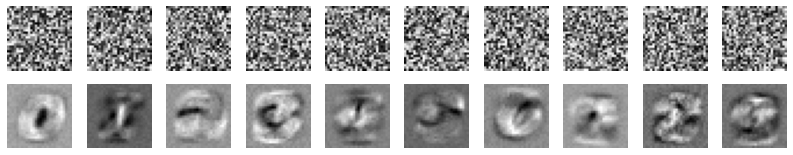

In [23]:
# Plot logistic regression weights before and after training
fig1, ax1 = plt.subplots(2, 10, figsize=(14, 2.6))
for digit in range(10):
    ax1[0, digit].imshow(np.reshape(weights_before[digit, :], newshape=(28, 28)), cmap='gray')
    ax1[1, digit].imshow(np.reshape(weights_after[digit, :], newshape=(28, 28)), cmap='gray')
    ax1[0, digit].axis('off')
    ax1[1, digit].axis('off')
plt.show()


## **5. Evaluating Logistic Regression Model on Test Set**

### 5.1. Evaluate model on test set

Once our model has been trained, we now need to evaluate it on a set of hold-out data, or a test set. Evaluating trained models on a test set is a critical step of machine learning pipelines, as this gives us an idea of how well our model will generalize in the real world to new, never-seen-before data.

First, we need to put our model in evaluation mode using the `eval()` method. This method affects operations with different training and test-time behavior such as dropout and batch normalization. Although we don't use any layers in this tutorial that would be affected by this method, it's a good thing to get into the habit of doing.

Additionally, since we aren't training our model any more via backpropagation, we don't need to compute a loss or calculate gradients. We can use the [`torch.no_grad()`](https://pytorch.org/docs/stable/generated/torch.no_grad.html) context-manager that disables gradient calculation. Disabling gradient calculation is useful for model inference, when you are sure that you will not call Tensor.backward(). Using `torch.no_grad()` will help reduce memory consumption for computations that would otherwise require gradients during training [6].


In [24]:
# Place model in evaluation mode
# .eval() method affects operations such as dropout and batch normalization
lr_model.eval()

# Initialize test set metrics variables
n_obs = 0
n_correct = 0

# Disable gradient calculation
with torch.no_grad():
    # Iterate through test data mini-batches
    for images_batch, labels_batch in test_loader:
        # Forward pass
        y_pred = lr_model(images_batch)  # model predictions

        # Update test set metrics variables
        n_batch = len(labels_batch)
        n_obs += n_batch
        n_correct += (y_pred.argmax(1)==labels_batch.long()).float().sum().item()

# Calculate test accuracy
acc_test = n_correct / n_obs

# Display test accuracy
print('\nLogistic regression model MNIST test acc.:  %.4f\n' % (acc_test))



Logistic regression model MNIST test acc.:  0.9220



## **6. Training and Evaluating Multi-Layer Perceptron on MNIST Dataset**

### 6.1. Defining MLP model

Similarly to how we previously defined our logistic regression model by using PyTorch's object-oriented style, we can implement a neural network/[multi-layer perceptron](https://machinelearningmastery.com/neural-networks-crash-course/) (MLP) with just a few tweaks. Instead of just one `Linear` layer, this time we'll use two. Additionally, after the first `Linear` layer we'll apply a non-linear [activation function](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/). Activation functions are a critical part of neural network design, and help give our neural network model added expressivity for modelling complex, non-linear relationships. The de facto nonlinearity used in neural networks is the [rectified linear unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (ReLU). We can implement this ReLU activation function as a layer in our MLP by using PyTorch's [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) layer.


*Note: multi-layer perceptron and artifical neural network (ANN) are often used interchangeably to describe a feed-forward, fully-connected neural network with many layers.*


In [25]:
# Multi-layer perceptron model
class MLP(nn.Module):
    """
    PyTorch implementation of a multi-layer perceptron model.
    
    Parameters
    ----------
    input_dim : int
        Size/dimensionality of the model input data.
    output_dim : int
        Size/dimensionality of the model output.
    hidden_dim : int
        Size/dimensionality of the hidden layer.
    
    Attributes
    ----------
    input_dim : int
        Size/dimensionality of the model input data.
    output_dim : int
        Size/dimensionality of the model output.
    hidden_dim : int
        Size/dimensionality of the hidden layer.
    linear_1 : torch.nn.Linear
        Fully-connected/linear neural network layer.
    linear_2 : torch.nn.Linear
        Fully-connected/linear neural network layer.
    relu : torch.nn.ReLU
        Rectified linear unit activation function.
    """
    
    # MLP instantiation method
    def __init__(self, input_dim, output_dim, hidden_dim=100):
        """
        Model instantiation method.
        
        Parameters
        ----------
        input_dim : int
            Size/dimensionality of the model input data.
        output_dim : int
            Size/dimensionality of the model output.
        hidden_dim : int
            Size/dimensionality of the hidden layer.

        Attributes
        ----------
        input_dim : int
            Size/dimensionality of the model input data.
        output_dim : int
            Size/dimensionality of the model output.
        hidden_dim : int
            Size/dimensionality of the hidden layer.
        linear_1 : torch.nn.Linear
            Fully-connected/linear neural network layer.
        linear_2 : torch.nn.Linear
            Fully-connected/linear neural network layer.
        relu : torch.nn.ReLU
            Rectified linear unit activation function.
        """
        
        # Inherit from torch.nn.Module
        super(MLP, self).__init__()
        
        # Assign MLP parameters to model attributes
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Define MLP layers
        self.linear_1 = nn.Linear(in_features=input_dim,
                                  out_features=hidden_dim,
                                  bias=True)
        self.linear_2 = nn.Linear(in_features=hidden_dim,
                                  out_features=output_dim,
                                  bias=True)
        
        # Define MLP activation function
        self.relu = nn.ReLU()
    
    # MLP forward pass method
    def forward(self, x):
        """
        MLP forward pass method.
        
        Parameters
        ----------
        x : torch.Tensor()
            Tensor of input data.
        
        Returns
        -------
        logits : torch.Tensor()
             Raw model predictions (not passed through sigmoid or softmax function).
        """
        
        # Forward pass through model
        x = self.linear_1(x)       # first fully-connected layer
        x = self.relu(x)           # non-linear activation transformation
        logits = self.linear_2(x)  # second fully-connected layer
        
        # Return model output
        return logits


### 6.2. Instantiate MLP model



In [26]:
# Define model input and output dimensions from data
input_dim = X_train.shape[1]                  # second dimension is data dimensionality
output_dim = len(np.unique(y_train.numpy()))  # output dim. is equal to number of unique labels

# Instantiate multi-layer perceptron model
mlp_model = MLP(input_dim=input_dim, output_dim=output_dim)


### 6.3. Re-define optimizer with MLP model parameters

Since a PyTorch optimizer is an object that keeps track of and updates model parameters, we need to re-define our optimizer with the parameters of our newly defined MLP model. We can keep the same learning rate of 0.1 as last time.


In [27]:
# Instantiate stochastic gradient descent (SGD) optimizer
lr = 0.1
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=lr)


### 6.4. Train MLP model on training data

Now we train our MLP model on MNIST. Ideally, since we have now defined a non-linear model with added expressivity by including a hidden layer and a non-linear activation function following this hidden layer, we would like to see better classification performance than that achieved by logistic regression. As we will see, these modifications do indeed result in better hand-written digit classification performance.

Even though we changed the type of model, we can keep the same exact training loop we developed for training logistic regression on MNIST.


In [28]:
# Number of training epochs (epochs = # of passes through data)
n_epochs = 10

# Time model training
print('\nTraining MLP model...\n')
time_start = time.time()

# Place model in training mode
# .train() method affects operations such as dropout and batch normalization
mlp_model.train()

# Train model/iterate over epochs
for epoch in range(n_epochs):
    # Initialize epoch metrics variables
    n_obs = 0
    loss_sum = 0
    n_correct = 0
    
    # Iterate through training data mini-batches
    for images_batch, labels_batch in train_loader:
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = mlp_model(images_batch)         # model predictions
        loss = loss_func(y_pred, labels_batch)  # loss function evaluation
        
        # Backward pass
        loss.backward()    # backpropagation
        optimizer.step()   # update parameters according to learning rate, gradients
        
        # Update epoch metrics variables
        n_batch = len(labels_batch)
        n_obs += n_batch
        loss_sum += n_batch * loss.item()
        n_correct += (y_pred.argmax(1)==labels_batch.long()).float().sum().item()
    
    # Calculate epoch training loss and training accuracy
    loss_train = loss_sum / n_obs
    acc_train = n_correct / n_obs
    
    # Display training progress
    prog_disp_freq = 1   # frequency of training progress display
    if (((epoch + 1) % prog_disp_freq) == 0) | (epoch == 0) | ((epoch + 1) == n_epochs):
        print('  E%02d | train loss: %s | train acc.: %s' % 
              (epoch + 1, '{:.4f}'.format(loss_train), '{:.4f}'.format(acc_train)))

# Time model training
time_end = time.time()
print('\nMLP model training complete.\n')
print('Time to train MLP model:  %.1f s\n' % (time_end - time_start))



Training MLP model...

  E01 | train loss: 0.5237 | train acc.: 0.8653
  E02 | train loss: 0.2728 | train acc.: 0.9215
  E03 | train loss: 0.2193 | train acc.: 0.9373
  E04 | train loss: 0.1843 | train acc.: 0.9469
  E05 | train loss: 0.1588 | train acc.: 0.9539
  E06 | train loss: 0.1392 | train acc.: 0.9604
  E07 | train loss: 0.1240 | train acc.: 0.9648
  E08 | train loss: 0.1109 | train acc.: 0.9686
  E09 | train loss: 0.1003 | train acc.: 0.9717
  E10 | train loss: 0.0918 | train acc.: 0.9742

MLP model training complete.

Time to train MLP model:  272.2 s



### 6.5. Evaluate MLP model on test set

We'll now evaluate our MLP model on the test set. The added expressivity and complexity of our model can be a double-edged sword. While this added complexity gives our model the capacity to learn more complex, non-linear relationships, we must now also be weary of [overfitting](https://www.ibm.com/cloud/learn/overfitting). Overfitting occurs when a model learns the information represented in training data to the point where it's performance on hold-out data is negatively influenced. Deep learning models can have millions (sometimes [billions](https://developer.nvidia.com/blog/openai-presents-gpt-3-a-175-billion-parameters-language-model/)!) of trainable parameters, which means that the number of model parameters can be greater than the number of data points on which the model is trained. These "over-parametrized" models can be prone to overfitting, especially in cases of small data. Here, we're hoping that our test accuracy is similar to our training accuracy of around 96%-97%. As we'll see, our model did not overfit the training set and achieves a comparable test set accuracy.


In [29]:
# Place model in evaluation mode
# .eval() method affects operations such as dropout and batch normalization
mlp_model.eval()

# Initialize test set metrics variables
n_obs = 0
n_correct = 0

# Disable gradient calculation
with torch.no_grad():
    # Iterate through test data mini-batches
    for images_batch, labels_batch in test_loader:
        # Forward pass
        y_pred = mlp_model(images_batch)  # model predictions

        # Update test set metrics variables
        n_batch = len(labels_batch)
        n_obs += n_batch
        n_correct += (y_pred.argmax(1)==labels_batch.long()).float().sum().item()

# Calculate test accuracy
acc_test = n_correct / n_obs

# Display test accuracy
print('\nMLP model MNIST test acc.:  %.4f\n' % (acc_test))



MLP model MNIST test acc.:  0.9704



## **7. Full Pipeline** - Training PyTorch Model on MNIST Dataset

Finally, we can combine our entire deep learning pipeline into a single cell.

In practice, when using Jupyter notebooks you shouldn't combine all of your code into a single cell, as this defeats the purpose of the modular nature of Jupyter notebooks. However, it can be helpful to see the entirety of a basic deep learning pipeline from beginning to end in code (without the extra bloat of my writing).


In [30]:
# -----------------
# IMPORT STATEMENTS
# -----------------

# Define random state
random_state = 0

# Import libraries, modules, and functions
import time
import numpy as np
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn


# -----------------------------------------------
# CLASS DEFINITIONS - MNIST DATASET AND MLP MODEL
# -----------------------------------------------

# MNIST PyTorch dataset object
class MNISTDataset(torch.utils.data.Dataset):  
    # MNIST PyTorch dataset instantiation method
    def __init__(self, X, y):
        # Assign attributes
        self.X = X         # flattened image data
        self.y = y         # image labels
        self.len = len(X)  # length of dataset

    # Dataset length method
    def __len__(self):
        # Return length of dataset
        return self.len

    # Dataset indexing method
    def __getitem__(self, idx):
        # Retrieve sample of data indexed by idx
        X_samp = self.X[idx, :]
        y_samp = self.y[idx]

        # Return data sample
        return X_samp, y_samp


# Multi-layer perceptron model
class MLP(nn.Module):
    # MLP instantiation method
    def __init__(self, input_dim, output_dim, hidden_dim=100):
        # Inherit from torch.nn.Module
        super(MLP, self).__init__()
        
        # Assign MLP parameters to model attributes
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Define MLP layers
        self.linear_1 = nn.Linear(in_features=input_dim,
                                  out_features=hidden_dim,
                                  bias=True)
        self.linear_2 = nn.Linear(in_features=hidden_dim,
                                  out_features=output_dim,
                                  bias=True)
        
        # Define MLP activation function
        self.relu = nn.ReLU()
    
    # MLP forward pass method
    def forward(self, x):
        # Forward pass through model
        x = self.linear_1(x)       # first fully-connected layer
        x = self.relu(x)           # non-linear activation transformation
        logits = self.linear_2(x)  # second fully-connected layer
        
        # Return model output
        return logits


# ---------------------------
# LOADING AND FORMATTING DATA
# ---------------------------

# Load NumPy arrays of MNIST dataset
mnist_data_dir = '/datasets/mnist/'
X_raw_train_npy = convert_from_file(mnist_data_dir + 'train-images-idx3-ubyte')
y_train_npy = convert_from_file(mnist_data_dir + 'train-labels-idx1-ubyte')
X_raw_test_npy = convert_from_file(mnist_data_dir + 't10k-images-idx3-ubyte')
y_test_npy = convert_from_file(mnist_data_dir + 't10k-labels-idx1-ubyte')

# Convert NumPy arrays to PyTorch tensors
X_raw_train = torch.from_numpy(X_raw_train_npy)
y_train = torch.from_numpy(y_train_npy)
X_raw_test = torch.from_numpy(X_raw_test_npy)
y_test = torch.from_numpy(y_test_npy)

# Convert image tensor type to float and labels tensor type to long
X_raw_train = X_raw_train.float()
X_raw_test = X_raw_test.float()
y_train = y_train.long()
y_test = y_test.long()

# Scale image pixel intensities between 0 and 1
X_train = X_raw_train / 255.0
X_test = X_raw_test / 255.0

# Reshape and "flatten" image data
X_train = X_train.view(X_train.shape[0], -1)
X_test = X_test.view(X_test.shape[0], -1)


# -------------------------------------------
# INSTANTIATE DATASET AND DATA LOADER OBJECTS
# -------------------------------------------

# Instantiate MNIST training and test PyTorch dataset objects
train_dataset = MNISTDataset(X_train, y_train)
test_dataset = MNISTDataset(X_test, y_test)

# Load the data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)


# -----------------------------------------------
# INSTANTIATE MODEL, LOSS FUNCTION, AND OPTIMIZER
# -----------------------------------------------

# Define model input and output dimensions from data
input_dim = X_train.shape[1]                  # second dimension is data dimensionality
output_dim = len(np.unique(y_train.numpy()))  # output dim. is equal to number of unique labels

# Instantiate model
# model = LogisticRegression(input_dim=input_dim, output_dim=output_dim)
model = MLP(input_dim=input_dim, output_dim=output_dim)

# Loss and Optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


# ----------------------------
# TRAIN MODEL ON TRAINING DATA
# ----------------------------

# Define number of training epochs
n_epochs = 10

# Time model training
print('\nTraining model...\n')
time_start = time.time()

# Place model in training mode
# .train() method affects operations such as dropout and batch normalization
model.train()

# Train model/iterate over epochs
for epoch in range(n_epochs):
    # Initialize epoch metrics variables
    n_obs = 0
    loss_sum = 0
    n_correct = 0
    
    # Iterate through training data mini-batches
    for images_batch, labels_batch in train_loader:
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(images_batch)            # model predictions
        loss = loss_func(y_pred, labels_batch)  # loss function evaluation
        
        # Backward pass
        loss.backward()   # backpropagation
        optimizer.step()  # update parameters according to learning rate, gradients
        
        # Update epoch metrics variables
        n_batch = len(labels_batch)
        n_obs += n_batch
        loss_sum += n_batch * loss.item()
        n_correct += (y_pred.argmax(1)==labels_batch.long()).float().sum().item()
    
    # Calculate epoch training loss and training accuracy
    loss_train = loss_sum / n_obs
    acc_train = n_correct / n_obs
    
    # Display training progress
    prog_disp_freq = 1   # frequency of training progress display
    if (((epoch + 1) % prog_disp_freq) == 0) | (epoch == 0) | ((epoch + 1) == n_epochs):
        print('  E%02d | train loss: %s | train acc.: %s' % 
              (epoch + 1, '{:.4f}'.format(loss_train), '{:.4f}'.format(acc_train)))

# Time model training
time_end = time.time()
print('\nModel training complete.\n')
print('Time to train model:  %.1f s\n' % (time_end - time_start))


# ---------------------------
# EVALUATE MODEL ON TEST DATA
# ---------------------------

# Place model in evaluation mode
# .eval() method affects operations such as dropout and batch normalization
model.eval()

# Initialize test set metrics variables
n_obs = 0
n_correct = 0

# Disable gradient calculation
with torch.no_grad():
    # Iterate through test data mini-batches
    for images_batch, labels_batch in test_loader:
        # Forward pass
        y_pred = model(images_batch)  # model predictions

        # Update test set metrics variables
        n_batch = len(labels_batch)
        n_obs += n_batch
        n_correct += (y_pred.argmax(1)==labels_batch.long()).float().sum().item()

# Calculate test accuracy
acc_test = n_correct / n_obs

# Display test accuracy
print('Model MNIST test acc.:  %.4f\n' % (acc_test))



Training model...

  E01 | train loss: 0.5182 | train acc.: 0.8657
  E02 | train loss: 0.2750 | train acc.: 0.9216
  E03 | train loss: 0.2208 | train acc.: 0.9375
  E04 | train loss: 0.1844 | train acc.: 0.9479
  E05 | train loss: 0.1575 | train acc.: 0.9551
  E06 | train loss: 0.1372 | train acc.: 0.9615
  E07 | train loss: 0.1211 | train acc.: 0.9657
  E08 | train loss: 0.1088 | train acc.: 0.9695
  E09 | train loss: 0.0987 | train acc.: 0.9722
  E10 | train loss: 0.0907 | train acc.: 0.9745

Model training complete.

Time to train model:  268.6 s

Model MNIST test acc.:  0.9682



## **References**

[1] https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

[2] https://pytorch.org/docs/stable/tensor_view.html

[3] https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

[4] https://pytorch.org/docs/stable/notes/modules.html

[5] https://pytorch.org/docs/stable/autograd.html, https://pytorch.org/docs/stable/optim.html

[6] https://pytorch.org/docs/stable/generated/torch.no_grad.html
